In [1]:
import proplot as plot
import numpy as np
import yaml
import glob
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "DEBUG"))

In [19]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect

with open(glob.glob("../runs/run0010_*/config.yaml")[0]) as fp:
    cfg = yaml.safe_load(fp.read())

In [21]:
import tqdm

for _ in tqdm.trange(1):
    seeds = np.random.randint(low=1, high=2**29, size=4)
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            **data,
            n_extra_noise_images=4,
        )

#     res = run_metadetect(
#         rng=mdet_rng,
#         config=cfg["metadetect"],
#         wcs=data["info"]["affine_wcs"],
#         image=cdata["image"],
#         bmask=cdata["bmask"],
#         ormask=cdata["ormask"],
#         noise=cdata["noise"],
#         psf=cdata["psf"],
#         weight=cdata["weight"],
#         mfrac=cdata["mfrac"],
#     )


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.99481797444372, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.4224602965067104)
DEBUG:pizza_cutter_sims.gals:using 'grid' layout
DEBUG:pizza_cutter_sims.gals:using 'exp-bright' gal type w/ mag 18.0
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_pizza_cutter._coadd_slic

100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


In [17]:
print(seeds)

[ 31960429  95914328 259491626  52565371]


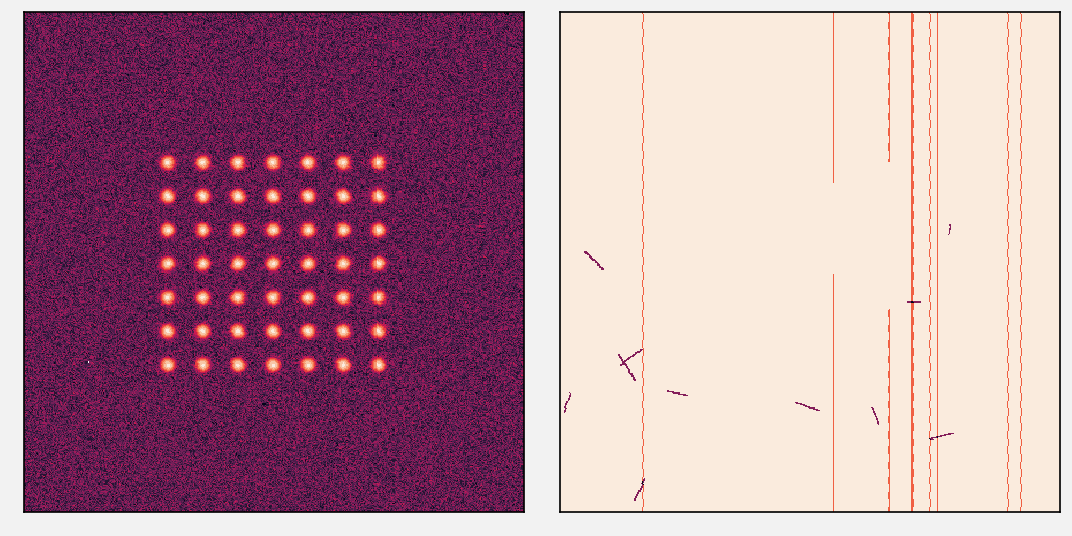

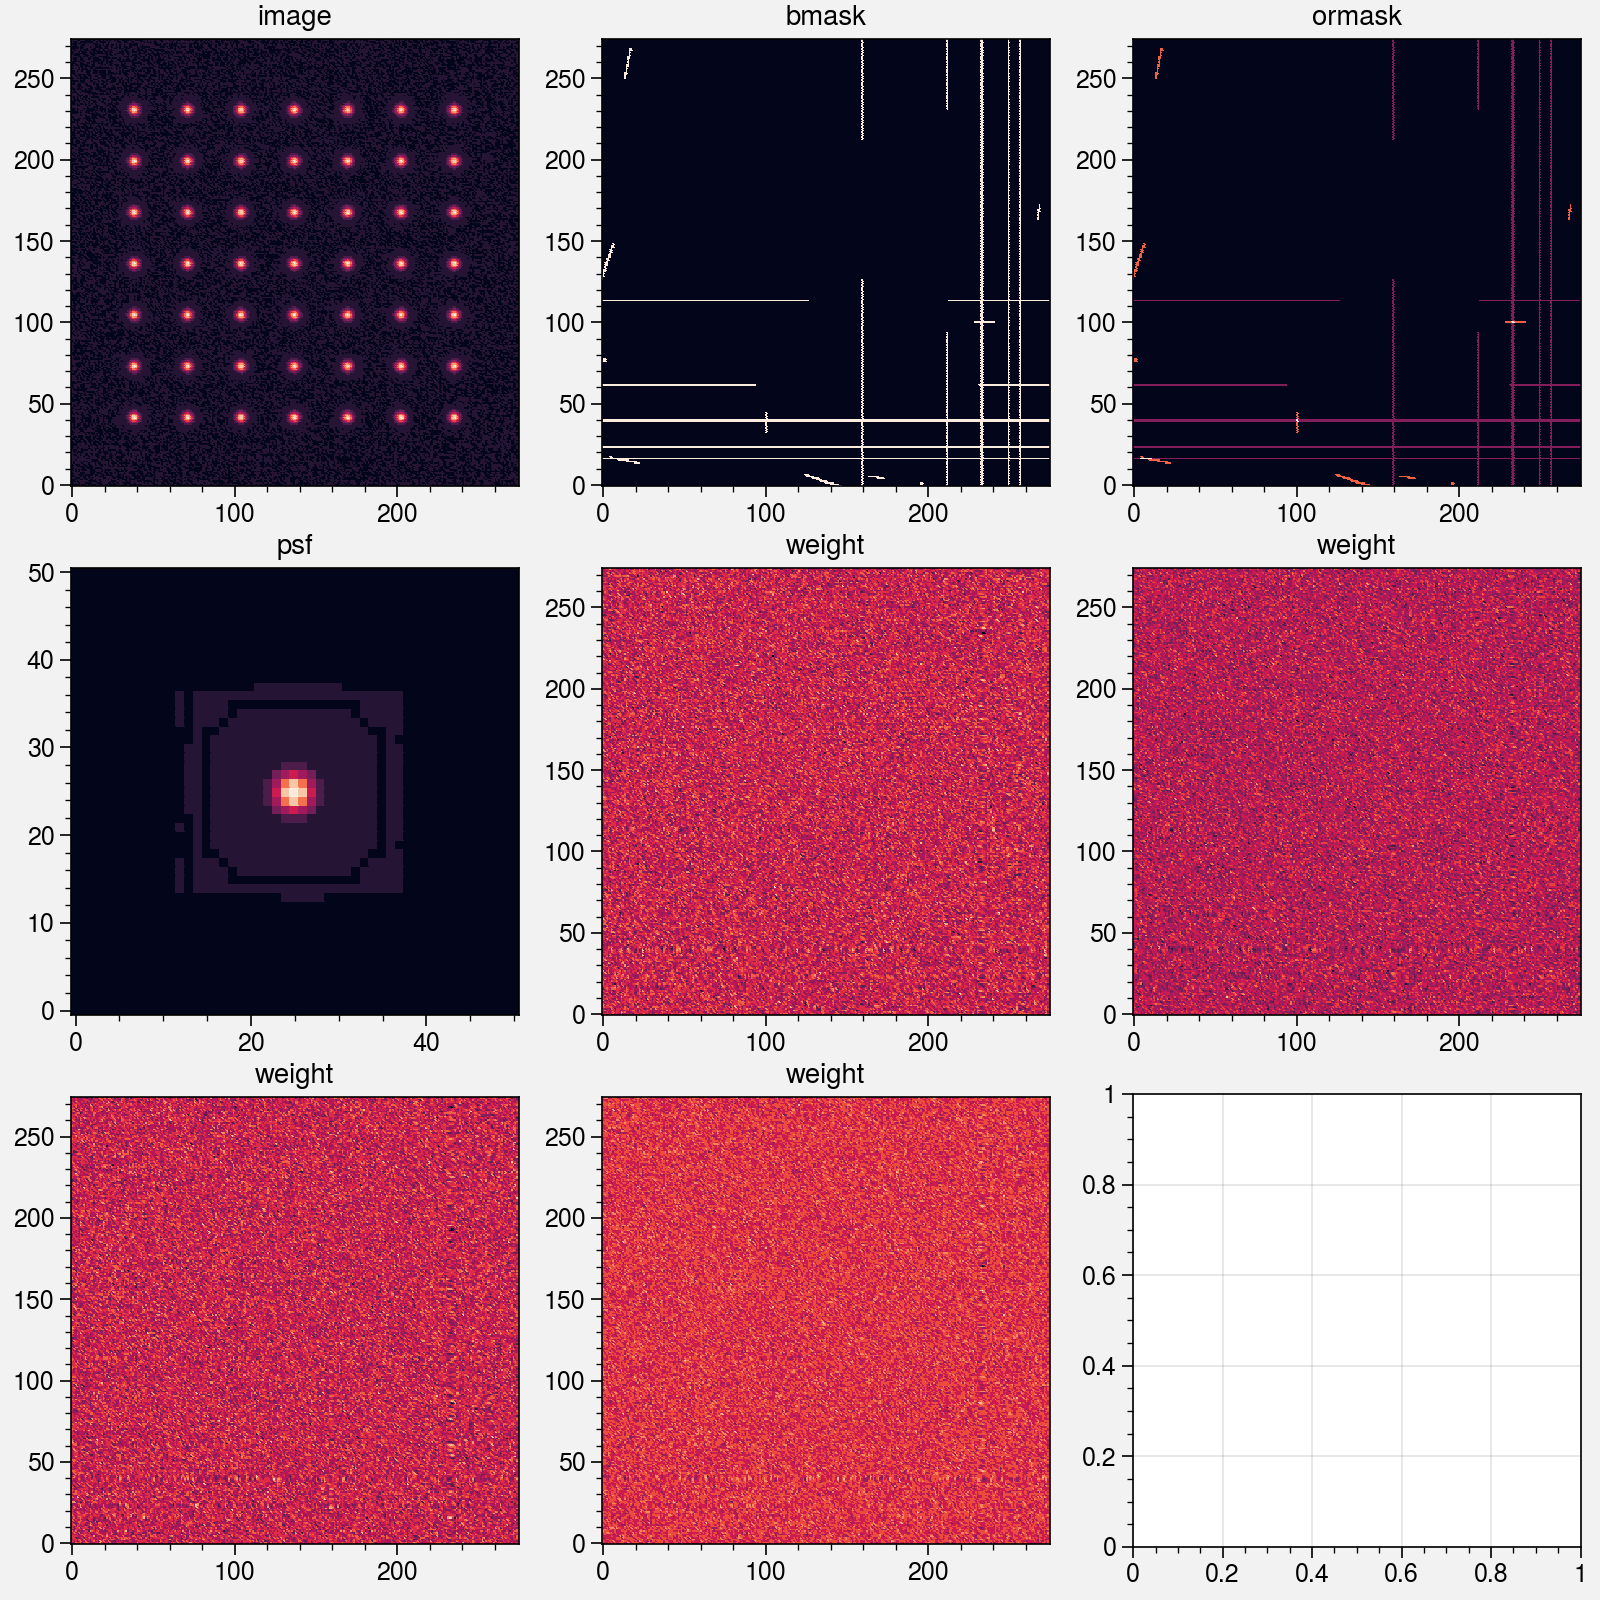

In [22]:
fig, axs = plot.subplots(nrows=len(data["img"]), ncols=2)

for i in range(len(data["img"])):
    axs[i, 0].pcolormesh(np.arcsinh(data["img"][i]*np.sqrt(data["wgt"][i])), cmap="rocket")
    axs[i, 0].set_aspect(1)
    axs[i, 0].xaxis.set_visible(False)
    axs[i, 0].yaxis.set_visible(False)
    axs[i, 1].pcolormesh(data["msk"][i], cmap="rocket_r")
    axs[i, 1].set_aspect(1)
    axs[i, 1].xaxis.set_visible(False)
    axs[i, 1].yaxis.set_visible(False)
    
fig, axs = plot.subplots(nrows=3, ncols=3, figsize=(8, 8), share=0)

for i, key in enumerate(["image", "bmask", "ormask", "psf", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)
for i in range(4, 8):
    axs[i].pcolormesh(cdata["extra_noises"][i-4], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)
    

/Users/beckermr/miniconda3/envs/desy6/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'masked fraction')

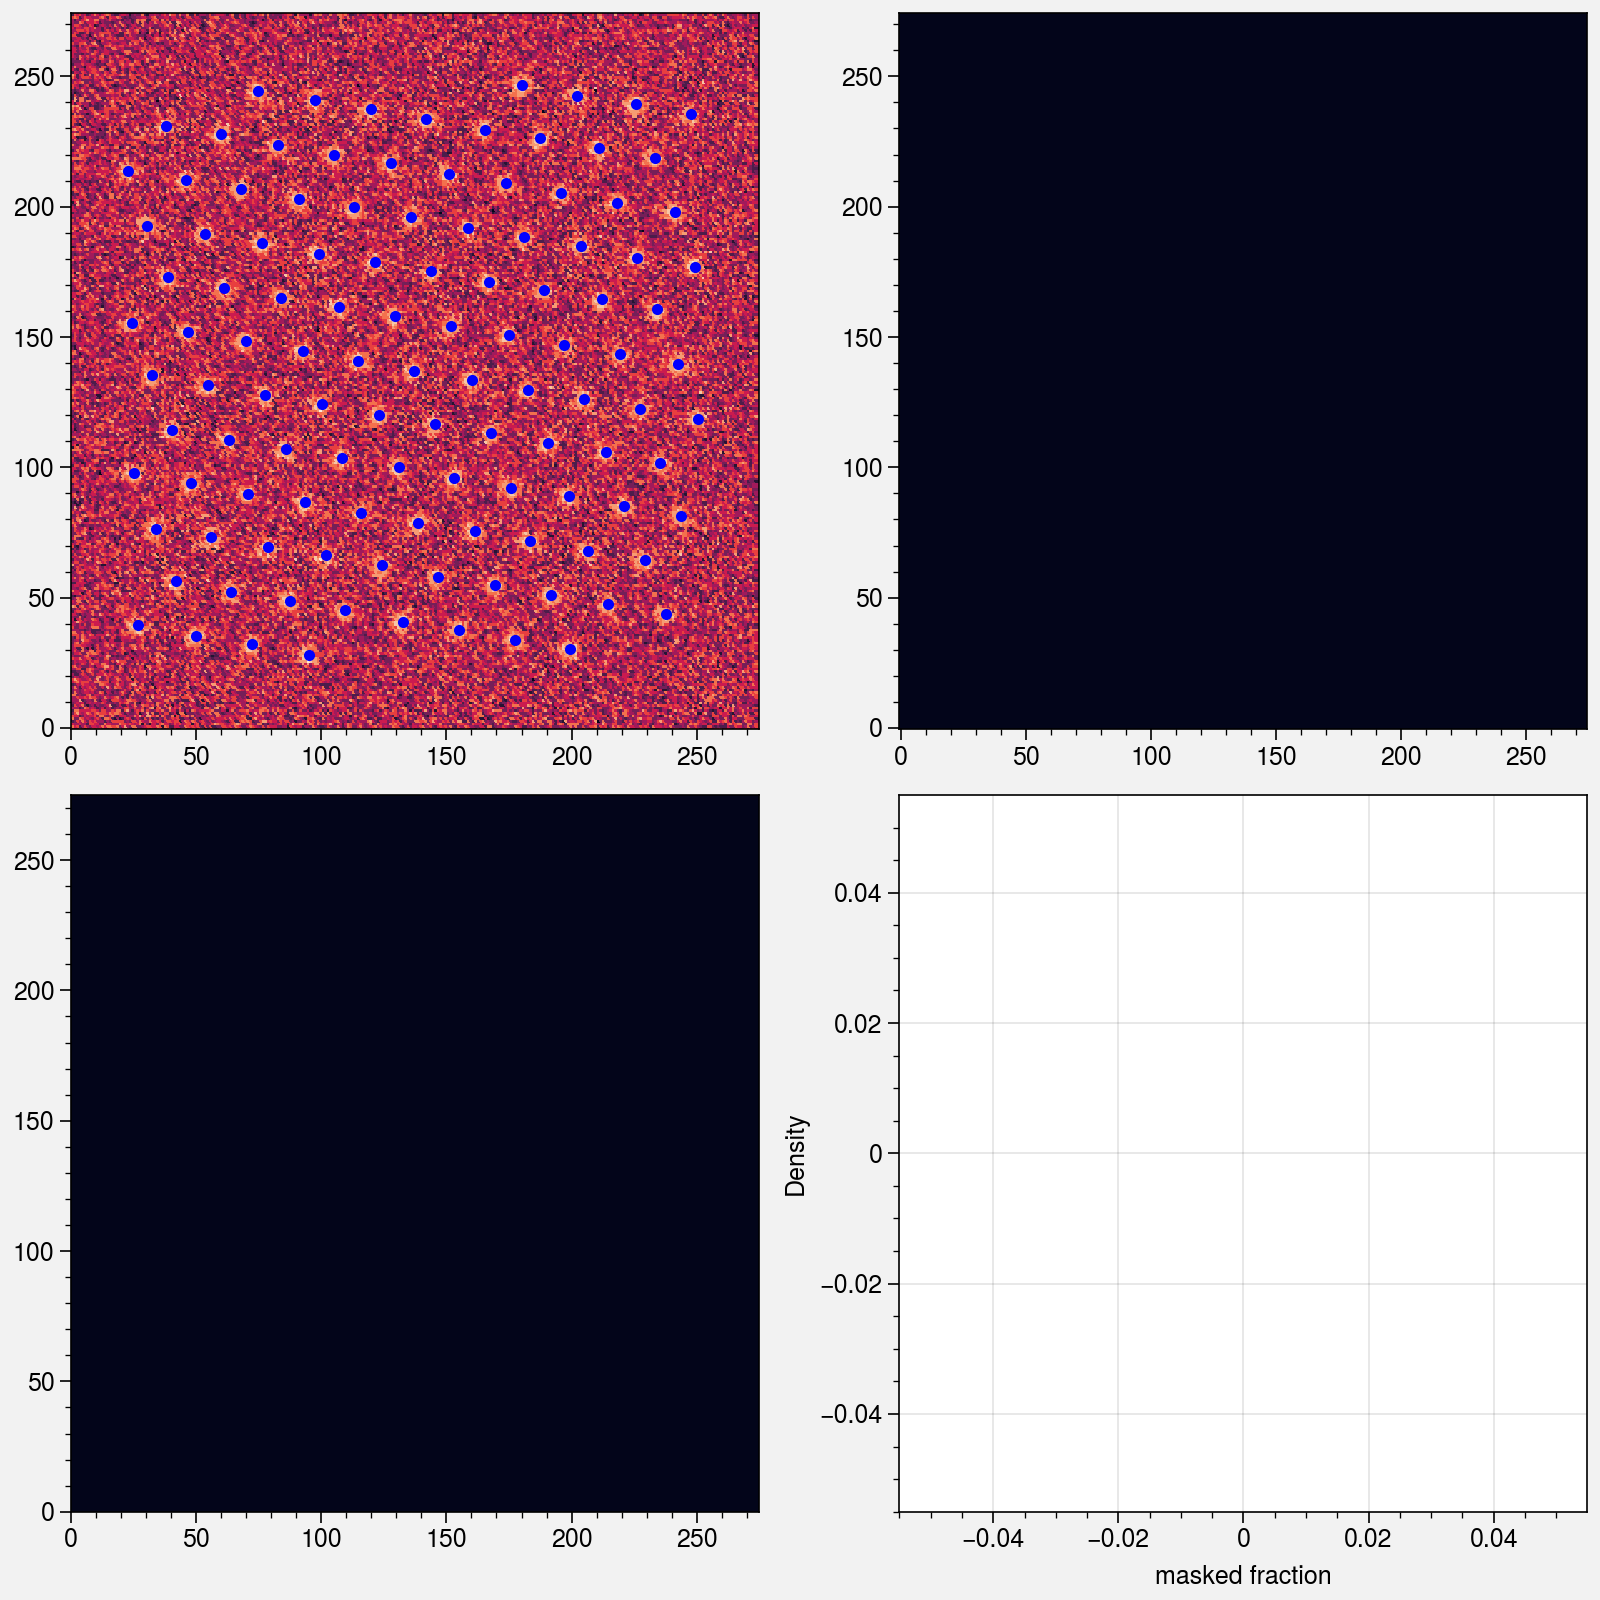

In [12]:
from scipy.interpolate import griddata

fig, axs = plot.subplots(nrows=2, ncols=2, figsize=(8, 8), share=0)

msk = res["noshear"]["ormask"] != 0
mmsk = res["noshear"]["mfrac"] > 0.1

axs[0, 0].pcolormesh(np.arcsinh(cdata["image"]* np.sqrt(cdata["weight"])), cmap="rocket")
axs[0, 0].plot(res["noshear"]["sx_col"], res["noshear"]["sx_row"], ".", color="blue")
axs[0, 0].plot(res["noshear"]["sx_col"][msk], res["noshear"]["sx_row"][msk], "o", color="orange")
axs[0, 0].plot(res["noshear"]["sx_col"][mmsk], res["noshear"]["sx_row"][mmsk], ".", color="yellow")
axs[0, 0].set_xlim(0, cdata["image"].shape[0])
axs[0, 1].pcolormesh(cdata["ormask"], cmap="rocket")

xyvals = np.linspace(0, cdata["image"].shape[0], 50)
gx, gy = np.meshgrid(xyvals, xyvals)
gx = gx.ravel()
gy = gy.ravel()
zvals = griddata(
    np.array([
        res["noshear"]["sx_col"], 
        res["noshear"]["sx_row"], 
    ]).T,
    res["noshear"]["mfrac"],
    np.array([gx, gy]).T,
    fill_value=0,
).reshape(xyvals.shape[0], xyvals.shape[0])

axs[1, 0].pcolormesh(xyvals, xyvals, zvals, cmap='rocket', vmin=0, vmax=1)
axs[1, 0].set_xlim(0, cdata["image"].shape[0])
axs[1, 0].set_ylim(0, cdata["image"].shape[0])

sns.kdeplot(res["noshear"]["mfrac"], ax=axs[1, 1], cut=0, bw_adjust=0.1)
axs[1, 1].set_xlabel("masked fraction")